In [2]:
import skimage.io as io
import skimage as sk
from skimage.color import rgb2gray
from skimage.transform import resize
import time
import numpy as np
import os
import copy


from unitTesting import UnitTest
import adaboost.adaboost as ab
import utilitis as ut

# Unit Testing

In [3]:
img = io.imread('./test.jpg')
img = rgb2gray(img)
unitTesting = UnitTest(img)

Integral image test PASSED
Total number of features = 273312
Determine features test FAILED. No of features : 273,312
Calculate sum test 1 PASSED
Calculate sum test 2 PASSED
Calculate sum test 3 PASSED
Feature value test 1 PASSED
Feature value test 2 PASSED


# Getting Datasets

In [5]:


#load positive dataset
try:
    print("Loading positive dataset...")
    positiveDataset = np.load("./Dataset/posTrain.npy")
except:
    print("No dataset found, creating new dataset...")
    positiveDataset = np.load("./Dataset/olivetti_faces.npy")
    personID = np.load("./Dataset/olivetti_faces_target.npy")


    #resize images to 24x24
    newPositiveDataset = np.empty(shape=(positiveDataset.shape[0], 24, 24))
    for i in range(len(positiveDataset)):
        newImg = np.array(positiveDataset[i])
        
        finalImg = resize(newImg, (24, 24))
        newPositiveDataset[i] = finalImg

    positiveDataset = newPositiveDataset

    # for i in range(10):
    #     io.imshow(positiveDataset[i])
    #     io.show()

    # print(positiveDataset.shape)

    

    # np.save("./Dataset/positiveDataset.npy", positiveDataset)
    # print("Positive Dataset saved")

#loading negative dataset
try:
    print("Loading negative dataset...")
    negativeDataset = np.load("./Dataset/negTrain.npy")
except:
    print("No dataset found, creating new dataset...")
    directory = "./Dataset/NegativeSet"
    negativeDataset = np.empty(shape=(len(os.listdir(directory)), 24, 24))
    i = 0
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            curImg = io.imread(os.path.join(directory, filename), as_gray=True)
            newImg = resize(curImg, (24, 24))
            negativeDataset[i] = newImg
            i += 1
    # negativeDataset = negativeDataset.reshape(len(os.listdir(directory)), 64, 64)
    # print(negativeDataset.shape)
    # np.save("./Dataset/negativeDataset.npy", negativeDataset)
    # print("Negative Dataset saved")



posDataset, negDataset = ut.preprocessImages(positiveDataset, negativeDataset)

print(f"Positive Dataset Shape: {posDataset.shape}")
print(f"Negative Dataset Shape: {negDataset.shape}")



Loading positive dataset...
Loading negative dataset...
Positive Dataset Shape: (300, 24, 24)
Negative Dataset Shape: (240, 24, 24)


# Training

In [6]:
minFeatureWidth = 1
maxFeatureWidth = 16
minFeatureHeight = 1
maxFeatureHeight = 16
nClassifiers = 10000
threshold = 0

classifiersToBeUsed = []
try :
    print("Loading classifiers...")
    classifiersToBeUsed = np.load("./classifiers.npy", allow_pickle=True)
except Exception as e:
    # print(e)
    print("No classifiers found, creating new classifiers...")
    classifier = ab.AdaBoost()
    start = time.time()
    classifiersToBeUsed = classifier.learn(posDataset, negDataset,threshold,minFeatureWidth,minFeatureHeight,maxFeatureWidth,maxFeatureHeight, nClassifiers)
    end = time.time()
    classifiersToBeUsed = np.array(classifiersToBeUsed)
    np.save("./classifiers"+str(nClassifiers)+"-" + str(threshold)+ "-"+str(minFeatureWidth)+"-" + str(maxFeatureWidth)+ ".npy", classifiersToBeUsed)
    print("Time taken to train the classifier: ", end-start)

print("Classifiers loaded successfully")








Loading classifiers...
Classifiers loaded successfully


# Testing

In [7]:
testDataSet = np.load("./Dataset/testMix.npy")
testDataSetTarget = np.load("./Dataset/testTargets.npy")
#convert to int 
testDataSetTarget = testDataSetTarget.astype(int)

print(f"Test Dataset Shape: {testDataSet.shape}")

#get integral images
ii = np.array([ut.integralImage(test) for test in testDataSet])

i = 0
correctCount = 0
firstWrong = 5
facesCount = 0
correctFacesCount = 0
correctNonFacesCount = 0
nonFacesCount = 0
for test in ii:
    predicted = ut.getVotes(np.array(classifiersToBeUsed), test)
    if predicted == testDataSetTarget[i]:
        correctCount += 1
        if predicted == 1:
            correctFacesCount += 1
        else:
            correctNonFacesCount += 1
    else:
        if firstWrong > 0:
            print("Predicted: ", predicted)
            print("Target: ", testDataSetTarget[i])
            # io.imshow(testDataSet[i])
            # io.show()
            firstWrong -= 1
    if testDataSetTarget[i] == 1:
        facesCount += 1
    if testDataSetTarget[i] == 0:
        nonFacesCount += 1
    
    i += 1

print("Accuracy: ", correctCount/len(testDataSet) * 100, "%")
print(f"Faces detected: {correctFacesCount} / {facesCount} , Accuracy: {correctFacesCount/facesCount * 100}%")
print(f"Non Faces detected: {correctNonFacesCount} / {nonFacesCount} , Accuracy: {correctNonFacesCount/nonFacesCount * 100}%")

Test Dataset Shape: (160, 24, 24)
Predicted:  0
Target:  1
Predicted:  1
Target:  0
Accuracy:  98.75 %
Faces detected: 99 / 100 , Accuracy: 99.0%
Non Faces detected: 59 / 60 , Accuracy: 98.33333333333333%


# Actual Run

In [12]:
def predict(img2) -> list:
    img = np.copy(img2)
    img = rgb2gray(img)
    img = img/img.max()
    img = img / np.var(img)


    ii = ut.integralImage(img)
    imgHeight, imgWidth = img.shape

    if imgHeight < 24 or imgWidth < 24:
        return []

    #scaling features
    maxScaleFactor = min(imgHeight/24, imgWidth/24)

    detectedFaces = []
    scaleFactor = 10
    shiftValue = 1
    while scaleFactor <= maxScaleFactor:
        scaledFeatures = copy.deepcopy(classifiersToBeUsed)
        scaledFeatures = [sf * float(scaleFactor) for sf in scaledFeatures]
        for x in range(0, int(imgWidth - (24 * scaleFactor)), int(np.round(shiftValue * scaleFactor)) ):
            scaledFeatures2 = copy.deepcopy(scaledFeatures)
            scaledFeatures2 = [sf + (x,0) for sf in scaledFeatures2]
            for y in range(0, int(imgHeight - (24 * scaleFactor)), int(np.round(shiftValue * scaleFactor))):
                # print(f"scale factor: {scaleFactor}, x: {x}, y: {y}")
                predicted = ut.getVotes(scaledFeatures2, ii)
                if predicted == 1:
                    detectedFaces.append([x, y, scaleFactor])
                scaledFeatures2 = [sf + (0,int(shiftValue * scaleFactor)) for sf in scaledFeatures2]
        print(f"finished scale factor: {scaleFactor}")
        scaleFactor += 1.25
    
    return detectedFaces



img = io.imread("./moazTest.jpg")

detectedFaces = predict(img)


finished scale factor: 10
finished scale factor: 11.25
finished scale factor: 12.5
finished scale factor: 13.75
finished scale factor: 15.0
finished scale factor: 16.25
finished scale factor: 17.5
finished scale factor: 18.75
finished scale factor: 20.0
finished scale factor: 21.25
finished scale factor: 22.5
finished scale factor: 23.75
finished scale factor: 25.0
finished scale factor: 26.25


Faces detected: 34


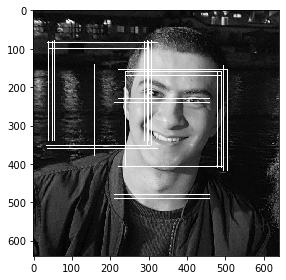

In [14]:
def drawRect(img2, x, y, scaleFactor):
    img = np.copy(img2)
    img = img/img.max()
    if len(img.shape) == 3:
        img = rgb2gray(img)
    # print(img.shape)
    imgHeight, imgWidth = img.shape
    x = int(x)
    y = int(y)
    scaleFactor = int(scaleFactor)
    for i in range(x, x + (24 * scaleFactor)):
        if i < imgWidth and y < imgHeight:
            img[y][i] = 1
        if i < imgWidth and y + (24 * scaleFactor) < imgHeight:
            img[y + (24 * scaleFactor)][i] = 1
    for i in range(y, y + (24 * scaleFactor)):
        if i < imgHeight and x < imgWidth:
            img[i][x] = 1
        if i < imgHeight and x + (24 * scaleFactor) < imgWidth:
            img[i][x + (24 * scaleFactor)] = 1
    return img

if len(detectedFaces) > 0:
    print(f"Faces detected: {len(detectedFaces)}")
    for face in detectedFaces:
        img = drawRect(img, face[0], face[1], face[2])
    io.imshow(img)
    io.show()
else:
    print("No faces detected")
